## Loading Imports

In [1]:
from copy import deepcopy
import os
from unicodedata import decimal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

# add imports for randomness
import time
import random

import sys

# Brevitas imports
import brevitas.nn as qnn
from brevitas.core.quant import QuantType
from brevitas.quant import Int32Bias
import torch.nn.functional as F

# For adaptive learning rate import
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split


## Define Target Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

Target device: cuda


## Load Dataset

Define the train and validation set sizes. Split dataset into train and validation sets.

Set the batch size. Create a dataloader for a training dataset with batch size of 1000.

### Data Augmentation

This code block applies data augmentation to the CIFAR-10 training dataset using transforms.RandomCrop and transforms.RandomHorizontalFlip. This randomly crops and flips the images in the dataset, which creates new variations of the original images. This technique is called data augmentation and can help prevent overfitting by increasing the diversity of the training dataset.

Additionally, this code block also normalizes the pixel values of both the training and validation datasets to have a mean of 0.5 and a standard deviation of 0.5 using transforms.Normalize.

Furthermore, the code block uses PyTorch DataLoader to create an iterator over the dataset that returns batches of data. This avoids the need for manual batch creation and helps to efficiently load and process the data.

Finally, this code block creates a DataLoader for the training and validation datasets with a batch size of 1000. This means that the model will process 1000 images at a time during training and validation, which can help to speed up the training process.

In [7]:
from torchvision import transforms

# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply data augmentation to the training dataset
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

# Use the validation transform for the validation dataset
val_set =torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transform)

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)


a = next(iter(train_loader))
print(a[0].size())
print(len(train_set))

print("Samples in each set: train = %d, test = %s" % (len(train_set), len(train_loader))) 
print("Shape of one input sample: " +  str(train_set[0][0].shape))

## Data Loader
#
# Using PyTorch dataloader we can create a convenient iterator over the dataset that returns batches of data, rather than requiring manual batch creation.

# set batch size
batch_size = 1000

# Create a DataLoader for a training dataset with a batch size of 100
train_quantized_loader = DataLoader(train_set, batch_size=batch_size)
test_quantized_loader = DataLoader(val_set, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([128, 3, 32, 32])
50000
Samples in each set: train = 50000, test = 391
Shape of one input sample: torch.Size([3, 32, 32])


In [8]:
count = 0

print("\nDataset Shape:\n-------------------------")
for x, y in train_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        break



Dataset Shape:
-------------------------
Input shape for 1 batch: torch.Size([128, 3, 32, 32])
Label shape for 1 batch: torch.Size([128])


## Define Model

There are 5 convolution layers and 2 Fully Connected QuantLinear Layers



In [9]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.quant_inp = qnn.QuantIdentity(bit_width=4, return_quant_tensor=True)

        self.layer1 = qnn.QuantConv2d(3, 32, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu1 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer2 = qnn.QuantConv2d(32, 32, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu2 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer3 = qnn.QuantConv2d(32, 64, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu3 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer4 = qnn.QuantConv2d(64, 64, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu4 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer5 = qnn.QuantConv2d(64, 64, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu5 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.fc1 = qnn.QuantLinear(64 * 8 * 8, 512, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu6 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.fc2 = qnn.QuantLinear(512, 10, bias=True, weight_bit_width=4, bias_quant=Int32Bias)

    def forward(self, x):
        x = self.quant_inp(x)
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = F.max_pool2d(x, 2)

        x = self.relu3(self.layer3(x))
        x = self.relu4(self.layer4(x))
        x = F.max_pool2d(x, 2)

        x = self.relu5(self.layer5(x))

        x = x.view(x.size(0), -1)

        x = self.relu6(self.fc1(x))
        x = self.fc2(x)

        return x

In [11]:
# Import testing
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import precision_recall_fscore_support

# Initialize the model, optimizer, and criterion
model = CIFAR10CNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
criterion = nn.CrossEntropyLoss()

num_epochs = 80
best_test_accuracy = 0
patience = 10
no_improvement_counter = 0

print(model)

CIFAR10CNN(
  (quant_inp): QuantIdentity(
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (act_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (fused_activation_quant_proxy): FusedActivationQuantProxy(
        (activation_impl): Identity()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClamp()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): ParameterFromRuntimeStatsScaling(
            (stats_input_view_shape_impl): OverTensorView()
            (stats): _Stats(
              (stats_impl): AbsPercentile()
            )
            (restrict_scaling): _RestrictValue(
              (restrict_value_impl): FloatRestrictValue()
            )
            (clamp_scaling): _ClampValue(
              (clamp_min_

## Train and Test

In [12]:
for epoch in range(num_epochs):

    # training phase
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
    
    # Initialize the validation loss
    val_loss = 0
    
    # testing phase
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()  # accumulate the validation loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
        val_loss /= len(val_loader)  # calculate the average validation loss
    
        # Update the learning rate using the validation loss
        scheduler.step(val_loss)

        test_accuracy = 100 * correct / total
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
        
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            
        if no_improvement_counter >= patience:
            print("Early stopping")
            break

        print('Epoch [{}/{}], Test Accuracy: {:.2f}%, Precision: {:.2f}, Recall: {:.2f}, F1 score: {:.2f}'.format(epoch+1, num_epochs, test_accuracy, precision, recall, f1))


Epoch [1/80], Step [100/391], Loss: 1.8972
Epoch [1/80], Step [200/391], Loss: 1.5202
Epoch [1/80], Step [300/391], Loss: 1.7359
Epoch [1/80], Test Accuracy: 49.24%, Precision: 0.52, Recall: 0.49, F1 score: 0.49
Epoch [2/80], Step [100/391], Loss: 1.3538
Epoch [2/80], Step [200/391], Loss: 1.1671
Epoch [2/80], Step [300/391], Loss: 1.1206
Epoch [2/80], Test Accuracy: 59.40%, Precision: 0.59, Recall: 0.59, F1 score: 0.57
Epoch [3/80], Step [100/391], Loss: 1.1277
Epoch [3/80], Step [200/391], Loss: 0.9731
Epoch [3/80], Step [300/391], Loss: 1.0713
Epoch [3/80], Test Accuracy: 64.78%, Precision: 0.64, Recall: 0.65, F1 score: 0.64
Epoch [4/80], Step [100/391], Loss: 1.0216
Epoch [4/80], Step [200/391], Loss: 0.9958
Epoch [4/80], Step [300/391], Loss: 0.9228
Epoch [4/80], Test Accuracy: 68.28%, Precision: 0.69, Recall: 0.68, F1 score: 0.68
Epoch [5/80], Step [100/391], Loss: 0.8728
Epoch [5/80], Step [200/391], Loss: 0.7728
Epoch [5/80], Step [300/391], Loss: 0.7903
Epoch [5/80], Test Accu

Epoch [39/80], Step [100/391], Loss: 0.2509
Epoch [39/80], Step [200/391], Loss: 0.1989
Epoch [39/80], Step [300/391], Loss: 0.2103
Epoch [39/80], Test Accuracy: 85.40%, Precision: 0.85, Recall: 0.85, F1 score: 0.85
Epoch [40/80], Step [100/391], Loss: 0.2970
Epoch [40/80], Step [200/391], Loss: 0.2483
Epoch [40/80], Step [300/391], Loss: 0.2940
Epoch [40/80], Test Accuracy: 85.17%, Precision: 0.85, Recall: 0.85, F1 score: 0.85
Epoch [41/80], Step [100/391], Loss: 0.3413
Epoch [41/80], Step [200/391], Loss: 0.2039
Epoch [41/80], Step [300/391], Loss: 0.3251
Epoch [41/80], Test Accuracy: 84.93%, Precision: 0.85, Recall: 0.85, F1 score: 0.85
Epoch [42/80], Step [100/391], Loss: 0.2876
Epoch [42/80], Step [200/391], Loss: 0.1971
Epoch [42/80], Step [300/391], Loss: 0.2656
Epoch [42/80], Test Accuracy: 84.87%, Precision: 0.85, Recall: 0.85, F1 score: 0.85
Epoch [43/80], Step [100/391], Loss: 0.2298
Epoch [43/80], Step [200/391], Loss: 0.2188
Epoch [43/80], Step [300/391], Loss: 0.2144
Epoc

In [19]:
# Print the best test accuracy
print("The final best test accuracy is: {:.2f}% at Epoch: {}".format(best_test_accuracy, epoch + 1))

The final best test accuracy is: 85.47% at Epoch: 55


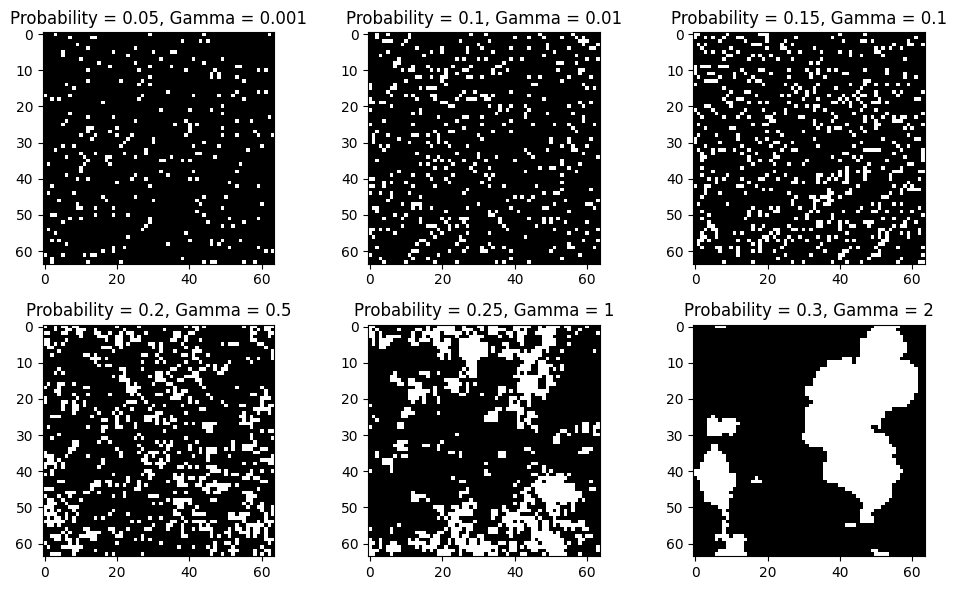

In [87]:
def random_clust_mask(N, P, gamma):
    
    # Generate random NxN matrix with values between 0 and 1
    matrix = np.random.rand(N, N)
    
    # Compute 2D FFTransform
    fft_result = np.fft.fft2(matrix)
    
    # 1D Frequency Vector with N bins
    f = np.fft.fftfreq(N)
    f[0] = 1e-6
    
    
    # Create a 2D filter in frequency space that varies inversely with freq over f
    # Gamma controls the falloff rate
    filter_2D = 1/(np.sqrt(f[:, None]**2 + f[None, :] ** 2)) ** gamma
    
    # Mult the 2D elementwise by the filter
    filtered_fft = fft_result * filter_2D
        
    # 2D inverse FFT of the filtered result
    ifft_result = np.fft.ifft2(filtered_fft)
    
    ifft_result = np.real(ifft_result)
    
    # Set the threshold T equal the the max value in IFFT
    T = ifft_result.max()
    
    # Init empty bool mask with same dims as ifft
    mask = np.zeros_like(ifft_result, dtype=bool)
    
    decrement_step = 0.01
    
    # Repeat until frac of nonzero values in the mask is greather than or equal to P
    while True:
        mask = ifft_result > T
        
        current_fraction = np.count_nonzero(mask) / (N * N)
        
        if current_fraction >= P:
            break
            
        T -= decrement_step

        
        # decrement_step = max(decrement_step * 0.99, 0.001)
    
    # Return tensor
 
    return torch.tensor(mask, dtype=torch.int)


def apply_mask_to_weights(layer, mask, P, gamma):
    
    # Get the size of the last dimension of layers weights
    N = layer.weight.data.size(-1)
    
    # Generate random clustered mask using function above
    mask = random_clust_mask(N, P, gamma)
    
    # Set the weights at the locations in mask to zero. 
    layer.weight.data[mask] = 0

        
# Testing
N = model.layer1.weight.data.size(-1)

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# Generate masks with different values for P
P_values = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
gamma_values = [1e-3, 0.01, 0.1, 0.5, 1, 2]

# Loop over subplots and generate mask for each value of P
for i, ax in enumerate(axs.flatten()):
    P = P_values[i]
    G = gamma_values[i]
    mask = random_clust_mask(64, P, G)
    ax.imshow(mask, cmap='gray')
    ax.set_title("Probability = {}, Gamma = {}".format(P, G))

# Adjust spacing between subplots
fig.tight_layout()

# Display the figure
plt.show()